# PME3481 - Controle e Aplicações

## Síntese pelo LQR - Regulador Linear Quadrático

Aqui, o objetivo é encontrar o LQR, bem como realizar o estudo da estabilidade segundo o critério de Lyapunov, e apresentar isso de forma concisa.

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import control as ctrl
import warnings
from scipy.optimize import minimize

In [2]:
warnings.simplefilter("ignore")  # Ignore all warnings

### Estabilidade segundo Lyapunov

A função de Lyapunov \(V(x)\) é positiva definida e contínua, com $V(x_e) = 0$ no ponto de equilíbrio $x_e$. A estabilidade do ponto de equilíbrio é então analisada observando o sinal de sua derivada ao longo das trajetórias do sistema.

Se a derivada da função de Lyapunov ao longo das trajetórias do sistema for negativa definida em uma vizinhança do ponto de equilíbrio, ou seja,

$$
\dot{V}(x) = \frac{{dV}}{{dt}} < 0, \quad \text{para} \quad x \neq x_e
$$

então o ponto de equilíbrio é considerado estável. Se $\dot{V}(x) < 0$ em uma vizinhança do ponto de equilíbrio e $\dot{V}(x) = 0$ apenas no ponto de equilíbrio, então o ponto de equilíbrio é assintoticamente estável.

In [3]:
def check_stability(A):
    """
    Check system stability using Lyapunov's method.
    
    Parameters:
        A (numpy.ndarray): State matrix.
    
    Returns:
        stable (bool): True if the system is stable, False otherwise.
    """
    # Solve the Lyapunov equation A.T @ P + P @ A = -I
    P = la.solve_lyapunov(A.T, -np.eye(A.shape[0]))
    
    # Check if the solution is positive definite
    stable = np.all(np.linalg.eigvals(P) > 0)
    return stable

### Definição das Funções e Organização

Função que retorna a matriz de ganho K segundo as penalizações defindias em Q e R, que indicam quais variáveis de estados devem ser consideradas mais importantes.

In [4]:
def lqr(A, B, Q, R):
    """    
    Parameters:
        A (numpy.ndarray): State matrix.
        B (numpy.ndarray): Input matrix.
        Q (numpy.ndarray): State cost matrix.
        R (numpy.ndarray): Input cost matrix.
    
    Returns:
        K (numpy.ndarray): Feedback gain matrix.
    """
    P = la.solve_continuous_are(A, B, Q, R)

    # Calculate the feedback gain matrix
    K = np.linalg.inv(R) @ B.T @ P
    return K

Definição do modelo dinâmico linear do foguete, que permite realizar os testes com as funções desenvolvidas acima.

In [5]:
Xcm = 1.052
Xpe = 0.261
L = 3.304
Df = 0.127
Tlin = 230.57
Izz = 15.07
M = 23.545
g = 9.8055
dar = 1.091
Cd = 0.432
Vxlin = -10.0
Vvlin = 2.2

In [6]:
# X = [theta,xp,yp,thetap]
# Xp = [thetap,xpp,ypp,thetapp]
# A = np.array([
#     [0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
#     [4.40301920e-01, -2.53575404e-03,  0.00000000e+00,  0.00000000e+00],
#     [-9.79343488e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
#     [4.91991402e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]
# ])
A = np.array([[0, 0, 0, 1],
              [(1/M)*((1/2)*dar*Cd*Vxlin**2*L*Df + (1/2)*dar*Cd*L*Df*Vvlin**2), (1/M)*(Vxlin *dar*Cd*((Df/2)**2*np.pi)), 0, 0],
              [(1/M)*(-M*g+(1/2)*Vxlin**2*dar*Cd*(np.pi*(Df/2)**2) - (1/2)*dar*Cd*(np.pi*(Df/2)**2)*Vvlin**2), 0, 0, 0],
              [(1/Izz)*((1/2)*Vxlin**2*dar*Xpe*Cd*(np.pi*(Df/2)**2)- (1/2)*dar*Cd*Xpe*(np.pi*(Df/2)**2)*Vvlin**2), 0, 0, 0]])

# u = [T,tau]

# B = np.array([[0, 0, 0],
#               [1/M, 0, 0],
#               [0, -Tlin/M, - (1/2)*dar*Cd*L*Df*2*Vvlin/M],
#               [0, -Tlin*Xcm/Izz, - (1/2)*dar*Cd*Xpe*L*Df*2*Vvlin/Izz]]) 

E = np.array([[0],
              [0],
              [ (- (1/2)*dar*Cd*L*Df*2*Vvlin)/(M)],
              [(- (1/2)*dar*Cd*Xpe*L*Df*2*Vvlin)/(Izz)]])



B = np.array([[0, 0],
              [1/M, 0],
              [0, -Tlin/M],
              [0, -Tlin*Xcm/Izz]])

C = np.array([
    [0.,  1.,  0.,  0.],
    [0.,  0.,  1.,  0.]
])

D = np.array([
    [0.,  0.],
    [0.,  0.]
])

cont = ctrl.StateSpace(A, B, C, D)

sys = ctrl.ss(A, B, C, D)
sys

<LinearIOSystem:sys[3]:['u[0]', 'u[1]']->['y[0]', 'y[1]']>

### Estudo da Estabilidade

In [7]:
stable = check_stability(A)
if stable:
    print("The system is stable according to Lyapunov's method.")
else:
    print("The system is unstable according to Lyapunov's method.")

The system is unstable according to Lyapunov's method.


### LQR

Definição das matrizes de custo - associadas à função de perda do LQR.

In [27]:
# Define Q, R matrices (cost matrices)
# Define state cost matrix Q
Q = np.diag([1, 10, 1, 1])       
  
R = np.diag([0.1, 50])
# Moderate penalty for control inputs

In [24]:
# Compute LQR controller
K = lqr(A, B, Q, R)

np.set_printoptions(precision=3, suppress=True)
print("LQR Feedback Gain Matrix (K):")
print(K)
K

LQR Feedback Gain Matrix (K):
[[ 0.418  9.892  0.312 -0.132]
 [-1.197 -0.044  0.141 -0.505]]


array([[ 0.418,  9.892,  0.312, -0.132],
       [-1.197, -0.044,  0.141, -0.505]])

#### Sistema em Malha Fechada

In [10]:
# Compute closed-loop system
Acl = A - np.dot(B, K)
syscl = ctrl.ss(Acl, B, C, D)
syscl

<LinearIOSystem:sys[4]:['u[0]', 'u[1]']->['y[0]', 'y[1]']>

In [11]:
u = [0, 0]
X0  = [0.1, 5, 0, 0]
tempo = np.linspace(0, 30, 400000)

t, amp,yr = ctrl.forced_response(syscl, tempo, 0 ,X0,return_x = 'True')

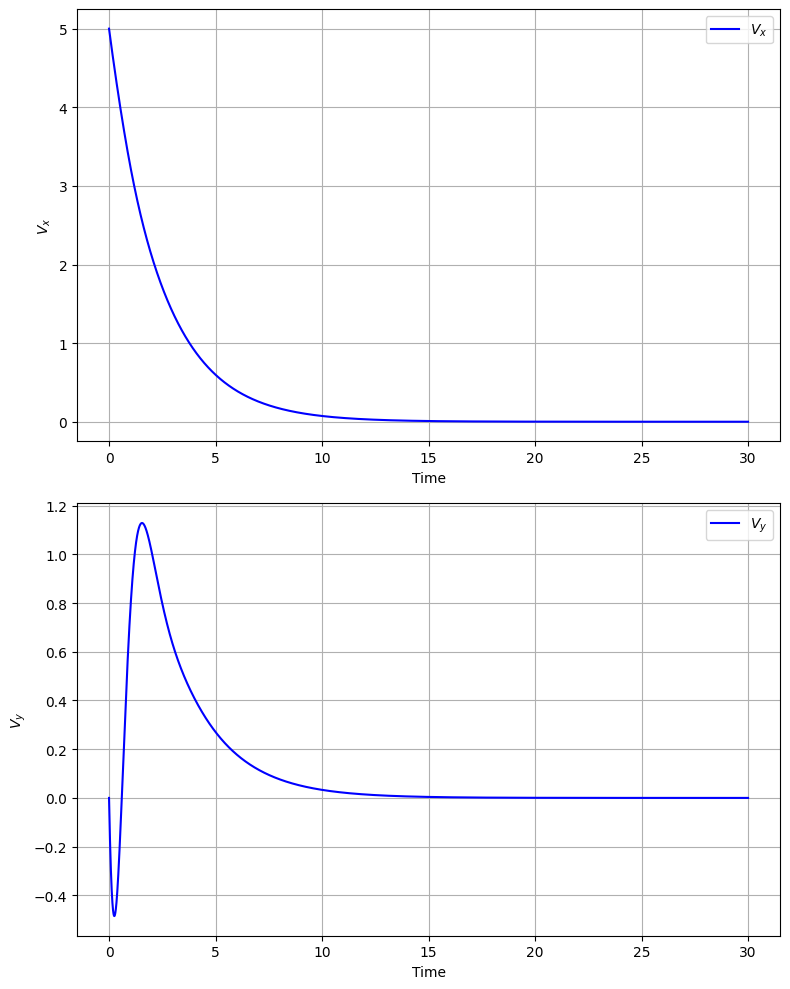

In [12]:
# Criando os subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
plt.grid(True)

# Plot Vx
axes[0].plot(t, yr[1], color='blue')
axes[0].set_ylabel(r'$V_x$')
axes[0].set_xlabel('Time')
axes[0].legend([r'$V_x$'], loc='upper right')
axes[0].grid(True)

# Plot Vy
axes[1].plot(t, yr[2], color='blue')
axes[1].set_ylabel(r'$V_y$')
axes[1].set_xlabel('Time')
axes[1].legend([r'$V_y$'], loc='upper right')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [13]:
u = np.dot(-K,yr)

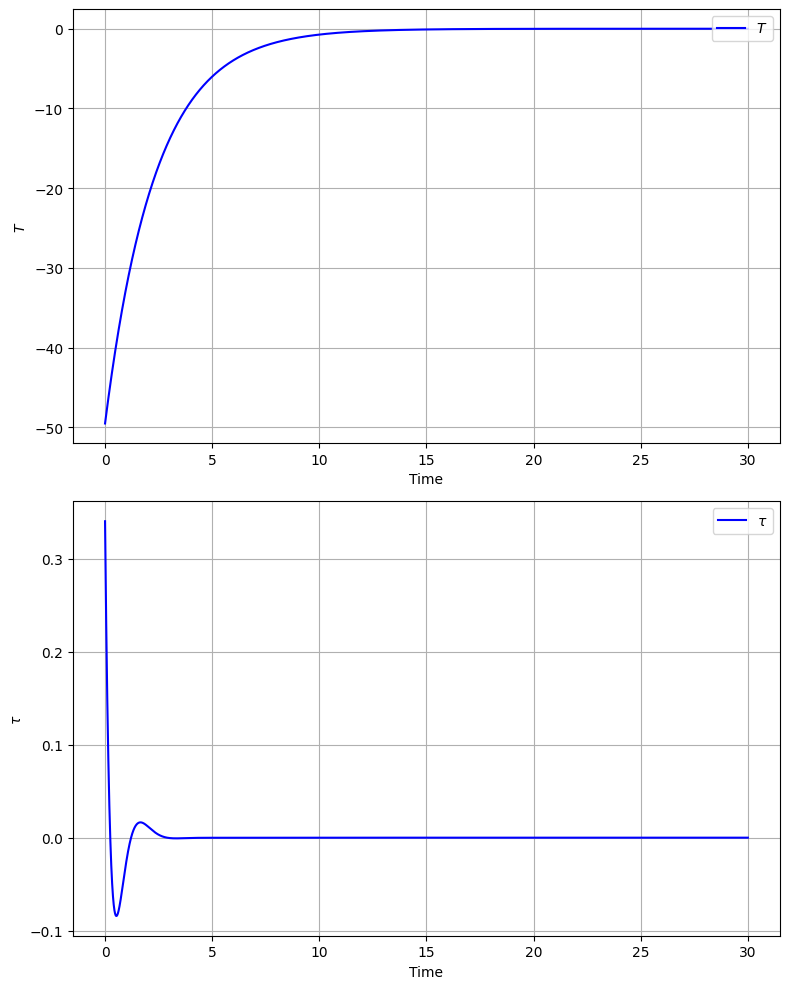

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Plot Theta
axes[0].plot(t, u[0], color='blue')
axes[0].set_ylabel(r'$T$')
axes[0].set_xlabel('Time')
axes[0].legend([r'$T$'], loc='upper right')
axes[0].grid(True)

# Plot VX
axes[1].plot(t, u[1], color='blue')
axes[1].set_ylabel(r'$\tau$')
axes[1].set_xlabel('Time')
axes[1].legend([r'$\tau$'], loc='upper right')
axes[1].grid(True)

plt.tight_layout()
plt.grid(True)
plt.show()

### Resposta com Perturbação

In [15]:
sys = ctrl.ss(Acl,E,C,0)
wn,z,pole = sys.damp()
pole

array([-2.021+2.053j, -2.021-2.053j, -2.715+0.j   , -0.42 +0.j   ])

In [16]:
def step(n,v):
    m1 = np.zeros(n//4)
    m3 = np.zeros(n-len(m1))
    m3 = m3 + v
    return np.block([m1,m3])

In [19]:
x0 = [0.1, 5, -1, 0.1]
# X0 = [0.2, 5, -1, 0.1] 
vento = 10
tempo = np.linspace(0, 30, 300000)

In [20]:
res = ctrl.forced_response(sys, tempo, step(len(tempo), vento), x0, return_x=True)
t, y, x = res

In [21]:
x = res.states
e = res.inputs

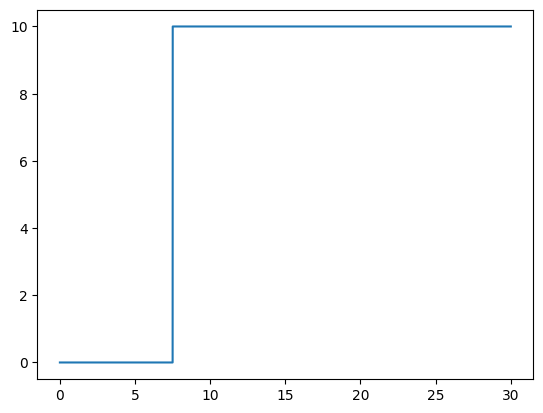

In [22]:
plt.plot(t,e[0])

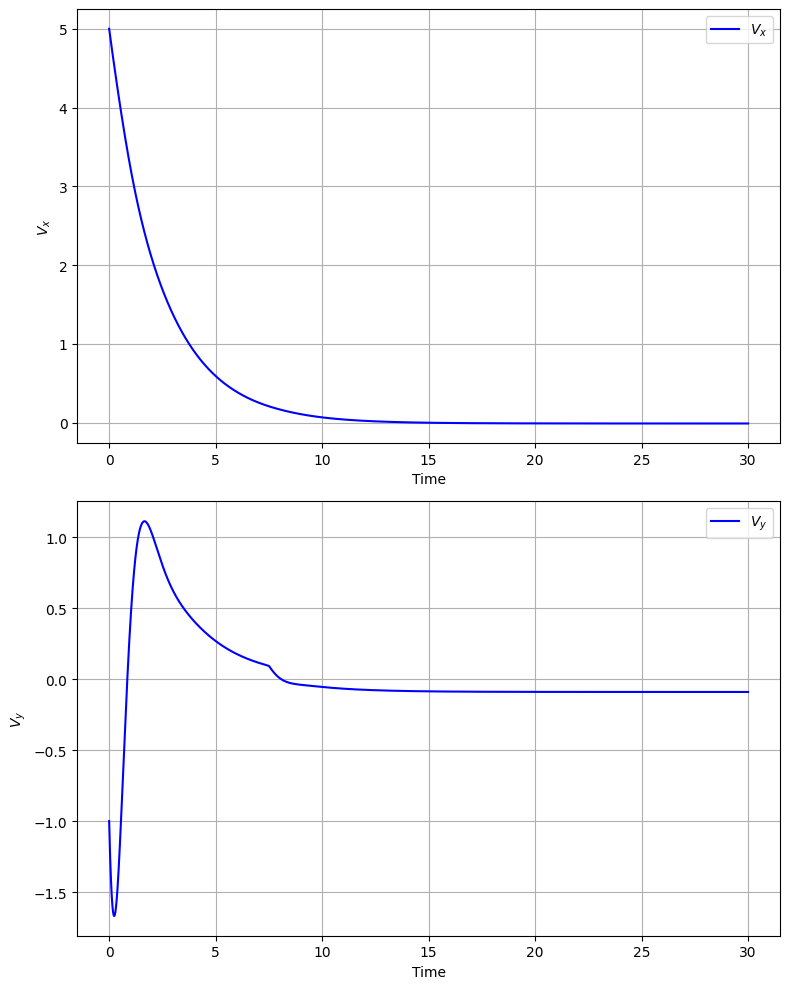

In [23]:
# Criando os subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Plot Vx
axes[0].plot(t, x[1], color='blue')
axes[0].set_ylabel(r'$V_x$')
axes[0].set_xlabel('Time')
axes[0].legend([r'$V_x$'], loc='upper right')
axes[0].grid(True)

# Plot Vy
axes[1].plot(t, x[2], color='blue')
axes[1].set_ylabel(r'$V_y$')
axes[1].set_xlabel('Time')
axes[1].legend([r'$V_y$'], loc='upper right')
axes[1].grid(True)

plt.tight_layout()
plt.show()

Text(0, 0.5, 'dθ (rad/s)')

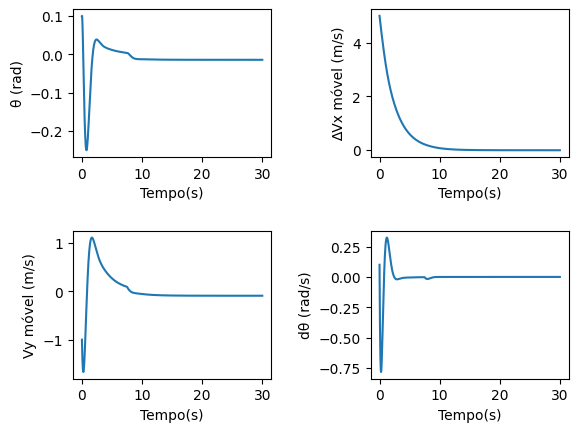

In [28]:
xsim = res.states

f,((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2)
plt.subplots_adjust( wspace=0.5,hspace=0.5)
ax1.set_xlabel('Tempo(s)')
ax2.set_xlabel('Tempo(s)')
ax3.set_xlabel('Tempo(s)')
ax4.set_xlabel('Tempo(s)')

ax1.plot(t, xsim[0])
ax1.set_ylabel('θ (rad)')
ax2.plot(t, xsim[1])
ax2.set_ylabel('∆Vx móvel (m/s)')
ax3.plot(t, xsim[2])
ax3.set_ylabel('Vy móvel (m/s)')
ax4.plot(t, xsim[3])
ax4.set_ylabel('dθ (rad/s)')